In [1]:
import tensorflow as tf
import torch

import checklist
from checklist.test_suite import TestSuite
from checklist.editor import Editor
from checklist.perturb import Perturb
from checklist.test_types import MFT, INV, DIR
from checklist.pred_wrapper import PredictorWrapper
from checklist.expect import Expect

from transformers import TrainingArguments, Trainer, Seq2SeqTrainer, InputExample, InputFeatures
from transformers import BertTokenizer, BertForSequenceClassification, TFBertForSequenceClassification
from transformers import EarlyStoppingCallback, pipeline, TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, RobertaTokenizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from autoviml.Auto_NLP import Auto_NLP

import pandas as pd
import numpy as np
import os
import shutil
import re
import string
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import nltk
nltk.download('brown')

Imported Auto_ViML version: 0.1.684. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)
            

Imported Auto_NLP version: 0.0.47.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


[nltk_data] Downloading package brown to
[nltk_data]     /Users/adambrownell/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [2]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
sentiment_task("T'estimo!") 

Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'Positive', 'score': 0.660058319568634}]

In [3]:
# Essays are out of order
"""
About Me / Self summary
Current Goals / Aspirations
My Golden Rule / My traits
I could probably beat you at / Talent
The last show I binged / Hobbies
A perfect day / Moments
I value / Needs
The most private thing I'm willing to admit / Secrets
What I'm actually looking for / Dating
"""

okcupid_data = pd.read_csv("okcupid_profiles.csv")

sentences = []
for i in range(10):
    d = okcupid_data['essay'+str(i)].values
    for essay in d:
        if type(essay) == str:
            sentences+= [sent for sent in essay.lower().split(".") if len(sent)>10]
            
okcupid_data.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,last_online,location,offspring,pets,religion,sign,smokes,speaks,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.00,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism and very serious about it,gemini,sometimes,english,"about me: i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes. about you: you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you should be able to bend spoons with your mind, and t...","currently working as an international agent for a freight forwarding company. import, export, domestic you know the works. online classes and trying to better myself in my free time. perhaps a hours worth of a good book or a video game on a lazy sunday.","making people laugh. ranting about a good salting. finding simplicity in complexity, and complexity in simplicity.","the way i look. i am a six foot half asian, half caucasian mutt. it makes it tough not to notice me, and for me to blend in.","books: absurdistan, the republic, of mice and men (only book that made me want to cry), catcher in the rye, the prince. movies: gladiator, operation valkyrie, the producers, down periscope. shows: the borgia, arrested development, game of thrones, monty python music: aesop rock, hail mary mallon, george thorogood and the delaware destroyers, felt food: i'm down for anything.",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am down for anything except a club.,i am new to california and looking for someone to wisper my secrets to.,you want to be swept off your feet! you are tired of the norm. you want to catch a coffee or a bite. or if you want to talk philosophy.
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,70.00,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn't have kids, but might want them",likes dogs and likes cats,agnosticism but not too serious about it,cancer,no,"english (fluently), spanish (poorly), french (poorly)",i am a chef: this is what that means. 1. i am a workaholic. 2. i love to cook regardless of whether i am at work. 3. i love to drink and eat foods that are probably really bad for me. 4. i love being around people that resemble line 1-3. i love the outdoors and i am an avid skier. if its snowing i will be in tahoe at the very least. i am a very confident and friendly. i'm not interested in acting or being a typical guy. i have no time or patience for rediculous acts of territorial pissing. overall i am a very likable easygoing individual. i am very adventurous and always looking forward to doing new things and hopefully sharing it with the right person.,dedicating everyday to being an unbelievable badass.,being silly. having ridiculous amonts of fun wherever. being a smart ass. ohh and i can cook. ;),NaN,i am die hard christopher moore fan. i don't really watch a lot of tv unl

# *******************
# REAL MODEL TESTING 
# *******************

# Sentiment Model Testing

## Models
- BERT (out-of-box)
- BERT (fine-tuned)
- reBERTa (out-of-box)
- roBERTa (out-of-box)
- TextBlob
- VADER
- AutoNLP


## Tests
- **Vocabulary + POS**: important words or groups of words (by part-of-speech) for the task
    - Single Word (pos/neg)
    - Single Word in Context (pos/neg)
    - Intensifier (pos/neg)
    - Reducers (pos/neg)
- **Taxonomy**: synonyms, antonyms, word categories, etc
- **Robustness**: to typos, irrelevant additions, contractions, etc
    - Irrelevant info
    - Typos
- **Named Entity Recognition (NER)**: person names, locations, numbers, etc
- **Fairness**
    - Race
    - Gender
    - Nationality
    - Religion
- **Temporal understanding**: understanding order of events and how they impact the task
- **Negation**
- **Coreference**
- **Semantic Role Labeling (SRL)**: understanding roles such as agent, object, passive/active, etc
- **Logic**: symmetry, consistency, conjunctions, disjunctions, etc

In [4]:
## Testing Data

URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

# The shutil module offers a number of high-level 
# operations on files and collections of files.

# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=1000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=1000, validation_split=0.2, 
    subset='validation', seed=123)

for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")


for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test_pd = pd.DataFrame([test_feat, test_lab]).T
test_pd.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test_pd['DATA_COLUMN'] = test_pd['DATA_COLUMN'].str.decode("utf-8")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-03-10 17:01:54.587936: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [5]:
def process_text(txt):
    
    txt = re.sub('-', ' ', txt)
    txt = re.sub('<br\s?\/>|<br>', "", txt)
    txt = re.sub('\"|\=|\:|\(|\)|\,|\.|\#|\;','',txt)
    txt = re.sub("\'","",txt)
    txt = re.sub("  "," ",txt)
    txt = txt.lower()
    return(txt)
    
train['DATA_COLUMN'] = train['DATA_COLUMN'].apply(process_text)
test_pd['DATA_COLUMN'] = test_pd['DATA_COLUMN'].apply(process_text)

In [6]:
editor = checklist.editor.Editor()
suite = TestSuite()

In [34]:
# Create [neg,pos] arrays for...

#### Most Popular Hugging Face Model ####
checkpoint = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
hf_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
hf_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def hf_func(inputs):
    
    tokens = hf_tokenizer(inputs, max_length=512, pad_to_max_length=True, truncation=True, return_tensors="np")
    preds = hf_model(tokens)[0].numpy()
    clean_preds = [[i[0],i[2]] for i in preds]
    
    return(np.array(clean_preds))
        
wrapped_hf = PredictorWrapper.wrap_softmax(hf_func)

#### TextBlog Model ####
def blob_func(inputs):
    
    scores = []
    for i in inputs:
        polar = TextBlob(i).sentiment.polarity
        if polar <0:
            scores.append([np.abs(polar),1+polar])
        else:
            scores.append([1-polar,np.abs(polar)])
    return(np.array(scores))

wrapped_blob = PredictorWrapper.wrap_softmax(blob_func)

#### VADER Model ####
analyzer = SentimentIntensityAnalyzer()

def vader_func(inputs):
    
    scores = []
    for i in inputs:
         polar = analyzer.polarity_scores(i)
         scores.append([polar['neg'],polar['pos']])
    return(np.array(scores))

wrapped_vader = PredictorWrapper.wrap_softmax(vader_func)

### Most Popular BERT Model ###
BERT_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def bert_untrain_func(inputs):
    
    tf_batch = bert_tokenizer(inputs, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = BERT_model(tf_batch)
    return(tf_outputs.logits.numpy())

wrapped_bert_untrain = PredictorWrapper.wrap_softmax(bert_untrain_func)
    

All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# #### BERT Fine-tuned ####

# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
#   train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
#                                                           text_a = x[DATA_COLUMN], 
#                                                           text_b = None,
#                                                           label = x[LABEL_COLUMN]), axis = 1)

#   validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
#                                                           text_a = x[DATA_COLUMN], 
#                                                           text_b = None,
#                                                           label = x[LABEL_COLUMN]), axis = 1)
  
#   return train_InputExamples, validation_InputExamples

#   train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
#                                                                            test, 
#                                                                            'DATA_COLUMN', 
#                                                                            'LABEL_COLUMN')
  
# def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
#     features = [] # -> will hold InputFeatures to be converted later

#     for e in examples:
#         # Documentation is really strong for this method, so please take a look at it
#         input_dict = tokenizer.encode_plus(
#             e.text_a,
#             add_special_tokens=True,
#             max_length=max_length, # truncates if len(s) > max_length
#             return_token_type_ids=True,
#             return_attention_mask=True,
#             pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
#             truncation=True
#         )

#         input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
#             input_dict["token_type_ids"], input_dict['attention_mask'])

#         features.append(
#             InputFeatures(
#                 input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
#             )
#         )

#     def gen():
#         for f in features:
#             yield (
#                 {
#                     "input_ids": f.input_ids,
#                     "attention_mask": f.attention_mask,
#                     "token_type_ids": f.token_type_ids,
#                 },
#                 f.label,
#             )

#     return tf.data.Dataset.from_generator(
#         gen,
#         ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
#         (
#             {
#                 "input_ids": tf.TensorShape([None]),
#                 "attention_mask": tf.TensorShape([None]),
#                 "token_type_ids": tf.TensorShape([None]),
#             },
#             tf.TensorShape([]),
#         ),
#     )


# ## TRAINING SUBSECTION

# DATA_COLUMN = 'DATA_COLUMN'
# LABEL_COLUMN = 'LABEL_COLUMN'

# train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test_pd, DATA_COLUMN, LABEL_COLUMN)

# train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
# train_data = train_data.shuffle(100).batch(32).repeat(2)

# validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
# validation_data = validation_data.batch(32)

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

# # Trained until 0.876 acc (4hrs)
# model.fit(train_data, epochs=2, validation_data=validation_data)


In [9]:
# model.save_pretrained("bert_ft030822")

In [10]:
bert_ft_model = TFBertForSequenceClassification.from_pretrained("bert_ft030822")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def bert_ft_func(inputs):
    
    tf_batch = bert_tokenizer(inputs, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = bert_ft_model(tf_batch)
    return(tf_outputs.logits.numpy())

wrapped_bert = PredictorWrapper.wrap_softmax(bert_ft_func) 

Some layers from the model checkpoint at bert_ft030822 were not used when initializing TFBertForSequenceClassification: ['dropout_227']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at bert_ft030822.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [12]:
# ### roBERTa Finetuned ###
# # Define pretrained tokenizer and model

# model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
# hf_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


# # ----- 1. Preprocess data -----#
# # Preprocess data
# X = list(train.DATA_COLUMN.values)
# y = [i if i == 0 else 2 for i in train.LABEL_COLUMN.values]

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
# X_train_tokenized = hf_tokenizer(X_train, padding=True, truncation=True, max_length=512)
# X_val_tokenized = hf_tokenizer(X_val, padding=True, truncation=True, max_length=512)

# # Create torch dataset
# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels=None):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {key: torch.tensor(val[idx],dtype=torch.int64) for key, val in self.encodings.items()}
#         if self.labels:
#             item["labels"] = torch.tensor(self.labels[idx],dtype=torch.int64)
#         return item

#     def __len__(self):
#         return len(self.encodings["input_ids"])

# train_dataset = Dataset(X_train_tokenized, y_train)
# val_dataset = Dataset(X_val_tokenized, y_val)

# size = 2500
# small_data = Dataset(hf_tokenizer(X_train[:size], padding=True, truncation=True, max_length=512), y_train[:size])
# small_val_data = Dataset(hf_tokenizer(X_val[:size], padding=True, truncation=True, max_length=512), y_val[:size])

# # ----- 2. Fine-tune pretrained model -----#
# # Define Trainer parameters
# def compute_metrics(p):
#     from collections import Counter
#     pred, labels = p
#     pred = np.array([np.array([p[0],p[2]])for p in pred])
#     pred = np.argmax(pred, axis=1)
#     labels = (labels/2).astype(int)

#     accuracy = accuracy_score(y_true=labels, y_pred=pred)
#     f1 = f1_score(y_true=labels, y_pred=pred)

#     return {"accuracy": accuracy, "f1": f1}

# print('define trainer')
# # Define Trainer
# args = TrainingArguments(
#     output_dir="output",
#     evaluation_strategy="epoch",
#     per_device_train_batch_size=128,
#     per_device_eval_batch_size=128,
#     num_train_epochs=3,
#     seed=0,
#     load_best_model_at_end=True,
# )
# trainer = Trainer(
#     model=model,
#     args=args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
# )

# # Train pre-trained model
# trainer.train()

# # model.save_pretrained("hf_ft030422")



In [13]:
# model.save_pretrained("hf_ft030622")

In [50]:
hf_ft_model = AutoModelForSequenceClassification.from_pretrained("hf_ft021621")
hf_ft_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# inputs = "i love you"
# tokens = hf_ft_tokenizer(inputs, padding=True, truncation=True, max_length=512)

def hf_ft_func(inputs):
    
    tokens = hf_ft_tokenizer(inputs, max_length=512, pad_to_max_length=True, truncation=True, return_tensors="pt")

    preds = hf_ft_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])

    preds = preds.logits.detach().numpy()[0]
    return(np.array([[preds[0],preds[2]]]))

hf_ft_func("i love you")

array([[-0.57024753,  5.608067  ]], dtype=float32)

Auto NLP processing on NLP Column: DATA_COLUMN
Shape of Train Data: 1000 rows
    Shape of Test Data: 1000 rows


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/adambrownell/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/adambrownell/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/adambrownell/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/adambrownell/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/adambrownell/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/adambrownell/nltk_data...
[nltk_data]    

    Added 9 summary columns for counts of words and characters in each row
Cleaning text in Train data for DATA_COLUMN column
    Faster text processing using clean_text function, since top_num_features is below 300
    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
        Time Taken for Processing text in data = 12 seconds
Train data Text cleaning completed. Time taken = 12 seconds

For target = LABEL_ENCODE

    For class = 0
Top 200 n-grams
: ['good', 'if', 'bad', 'see', 'watch', 'they', 'there', 'who', 'what', 'time', 'even', 'no', 'go', 'would', 'his', 'dont', 'story', 'really', 'think', 'when', 'he', 'character', 'look', 'me', 'which', 'much', 'could', 'end', 'how', 'because', 'well', 'actor', 'ever', 'scene', 'people', 'plot', 'nothing', 'know', 'first', 'come', 'their', 'will', 'act', 'we', 'her', 'give', 'after', 'minute', 'thing', 'seem', 'want', 'she', 'off', 'take', 'great', 'them', 'try', 'show', 'way', 'back', 'should', 'why', 'waste', 'your', 'man

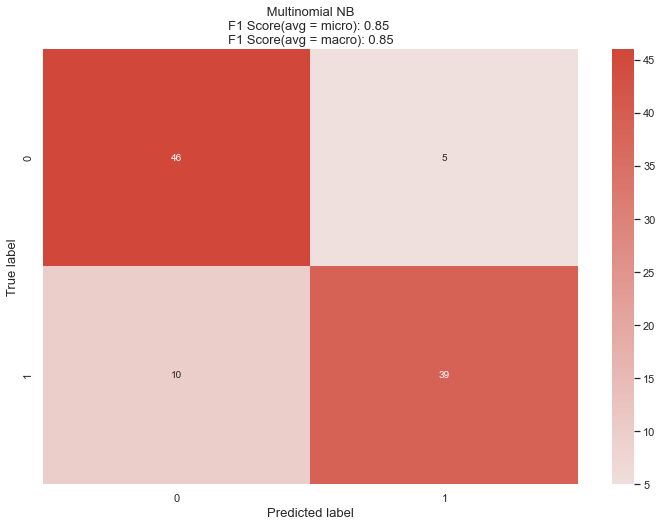

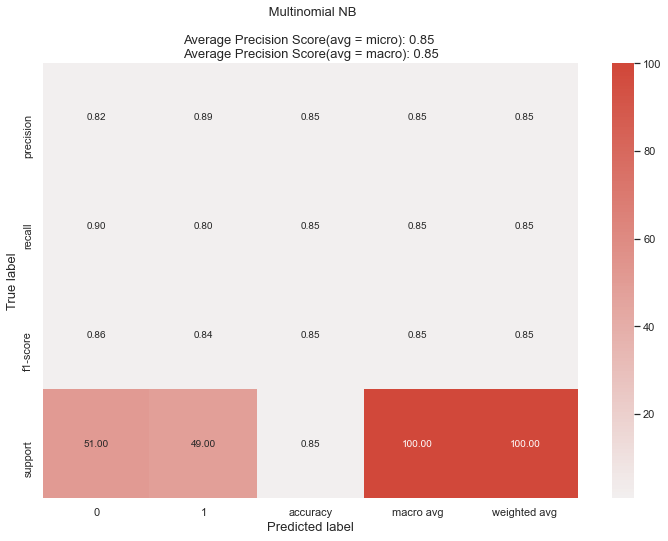

  Now transforming Train data to return as output...
    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
        Time Taken for Processing text in data = 7 seconds
  Transforming Test data to return as output...
    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
        Time Taken for Processing text in data = 10 seconds
Training best Auto_NLP Pipeline on full Train data...will be faster since best params are known
    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
        Time Taken for Processing text in data = 7 seconds
    Returning best Auto_NLP pipeline to transform and make predictions on test data...
    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
        Time Taken for Processing text in data = 9 seconds
Training completed. Time taken for Auto_NLP = 1.8 minutes
#########          A U T O   N L P  C O M P L E T E D    ###############################


In [16]:
### AUTOML ###
# https://analyticsindiamag.com/hands-on-guide-to-using-autonlp-for-automating-sentiment-analysis/
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train['LABEL_ENCODE'] = label_encoder.fit_transform(train.LABEL_COLUMN)
test_pd['LABEL_ENCODE'] = label_encoder.fit_transform(test_pd.LABEL_COLUMN)

train_x, test_x, final, predicted = Auto_NLP("DATA_COLUMN", 
                                             train, test_pd, 
                                             "LABEL_ENCODE", 
                                             score_type="balanced_accuracy",
                                             top_num_features=100,
                                             modeltype="Classification", 
                                             verbose=0, build_model=True)

In [18]:
def automl_func(inputs):
    preds = []
    if type(inputs) == str:
        inputs = list(inputs)
    for i in inputs:
        input_pd = pd.DataFrame({"DATA_COLUMN":[i]})
        p = final.predict_proba(input_pd)
        preds.append(final.predict_proba(input_pd)[0])
    return(np.array(preds))
    
wrapped_aml = PredictorWrapper.wrap_softmax(automl_func)

automl_func(["I love you"])

    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
        Time Taken for Processing text in data = 0 seconds
    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
        Time Taken for Processing text in data = 0 seconds


array([[0., 1.]])

## Vocab Testing

In [40]:
# Vocab
hs_nouns = ['app','session', 'WakeUp','customer service',
            'meditation','animation','quote','notification', 
            'recommendation','video','exercise','design',
            'meditation','sleepcast','voice','feature', 'HS employee',
            'chat session', 'experience']

editor.add_lexicon('hs_nouns', hs_nouns)

In [41]:
pos_adj = ['good', 'great', 'excellent', 'amazing', 'extraordinary', 'beautiful', 'fantastic', 'nice', 'incredible', 'exceptional', 'awesome', 'perfect', 'fun', 'happy', 'adorable', 'brilliant', 'exciting', 'sweet', 'wonderful']
neg_adj = ['awful', 'bad', 'horrible', 'weird', 'rough', 'lousy', 'unhappy', 'average', 'difficult', 'poor', 'sad', 'frustrating', 'hard', 'lame', 'nasty', 'annoying', 'boring', 'creepy', 'dreadful', 'ridiculous', 'terrible', 'ugly', 'unpleasant']

pos_verb_present = ['like', 'enjoy', 'appreciate', 'love',  'recommend', 'admire', 'value', 'welcome']
neg_verb_present = ['hate', 'dislike', 'regret',  'abhor', 'dread', 'despise' ]

pos_verb_past = ['liked', 'enjoyed', 'appreciated', 'loved', 'admired', 'valued', 'welcomed']
neg_verb_past = ['hated', 'disliked', 'regretted',  'abhorred', 'dreaded', 'despised']


editor.add_lexicon('pos_adj', pos_adj, overwrite=True)
editor.add_lexicon('neg_adj', neg_adj, overwrite=True )

editor.add_lexicon('pos_verb_present', pos_verb_present, overwrite=True)
editor.add_lexicon('neg_verb_present', neg_verb_present, overwrite=True)

editor.add_lexicon('pos_verb_past', pos_verb_past, overwrite=True)
editor.add_lexicon('neg_verb_past', neg_verb_past, overwrite=True)

editor.add_lexicon('pos_verb', pos_verb_present+ pos_verb_past, overwrite=True)
editor.add_lexicon('neg_verb', neg_verb_present + neg_verb_past, overwrite=True)

In [18]:
# Single Positive Word Vocab Test
test = MFT(pos_adj + pos_verb_present + pos_verb_past, labels=1)
suite.add(test, 'single positive words', 'Vocabulary', '')

# Single Negative Word Vocab Test
test = MFT(neg_adj + neg_verb_present + neg_verb_past, labels=0)
suite.add(test, 'single negative words', 'Vocabulary', '')

In [19]:
## Pos/Neg adjective in context Test

t = editor.template('{it} {hs_nouns} {be} {pos_adj}.',
                    it=['The', 'This', 'That'], be=['is', 'was'], labels=1, save=True)
t += editor.template('{it} {be} {a:pos_adj} {hs_nouns}.', 
                     it=['It', 'This', 'That'], be=['is', 'was'], labels=1, save=True)
t += editor.template('{i} {pos_verb} {the} {hs_nouns}.', 
                     i=['I', 'We'], the=['this', 'that', 'the'], labels=1, save=True)
t += editor.template('{it} {hs_nouns} {be} {neg_adj}.', 
                     it=['That', 'This', 'The'], be=['is', 'was'], labels=0, save=True)
t += editor.template('{it} {be} {a:neg_adj} {hs_nouns}.', 
                     it=['It', 'This', 'That'], be=['is', 'was'], labels=0, save=True)
t += editor.template('{i} {neg_verb} {the} {hs_nouns}.', 
                     i=['I', 'We'], the=['this', 'that', 'the'], labels=0, save=True)

# equivalent to:
# test = MFT(t.data, labels=t.labels, templates=t.templates)
test = MFT(**t)
suite.add(test, 'Sentiment-laden words in context', 'Vocabulary', 'Use positive and negative verbs and adjectives with Headspace nouns such as app, session, meditation, "This was a bad notification"')


In [20]:
intens_adj = ['very', 'really', 'absolutely', 'truly', 'extremely', 
              'quite', 'incredibly', 'amazingly', 'especially', 
              'exceptionally', 'unbelievably', 'utterly', 'exceedingly', 
              'rather', 'totally', 'particularly']

intens_verb = [ 'really', 'absolutely', 'truly', 'extremely', 
               'especially',  'utterly',  'totally', 'particularly',
               'highly', 'definitely', 'certainly', 'genuinely',
               'honestly', 'strongly', 'sure', 'sincerely']


In [21]:

t = editor.template(['{it} {be} {a:pos_adj} {hs_nouns}.', 
                     '{it} {be} {a:intens} {pos_adj} {hs_nouns}.'] , 
                    intens=intens_adj, it=['It', 'This', 'That'], be=['is', 'was'], nsamples=500, save=True)
t += editor.template(['{i} {pos_verb} {the} {hs_nouns}.', 
                      '{i} {intens} {pos_verb} {the} {hs_nouns}.'], 
                     intens=intens_verb, i=['I', 'We'], the=['this', 'that', 'the'], nsamples=500, save=True)
t += editor.template(['{it} {be} {a:neg_adj} {hs_nouns}.', 
                      '{it} {be} {a:intens} {neg_adj} {hs_nouns}.'] , 
                     intens=intens_adj, it=['It', 'This', 'That'], be=['is', 'was'], nsamples=500, save=True)
t += editor.template(['{i} {neg_verb} {the} {hs_nouns}.',
                      '{i} {intens} {neg_verb} {the} {hs_nouns}.'],
                     intens=intens_adj, i=['I', 'We'], the=['this', 'that', 'the'], nsamples=500, save=True)

# Adding intensity strictly increases our sentiment prediction Test
monotonic_label = Expect.monotonic(increasing=True, tolerance=0.1)

test = DIR(t.data, monotonic_label, templates=t.templates)
suite.add(test, 'intensifiers', 'Vocabulary', "Intensity Modifier Test")

In [22]:
reducer_adj = ['somewhat', 'kinda', 'mostly', 'probably', 'generally', 
               'reasonably', 'a little', 'a bit', 'slightly']

monotonic_label_down = Expect.monotonic(increasing=False, tolerance=0.1)

t = editor.template(['{it} {hs_nouns} {be} {pos_adj}.',
                     '{it} {hs_nouns} {be} {red} {pos_adj}.'] ,
                    red=reducer_adj, it=['The', 'This', 'That'], be=['is', 'was'], nsamples=1000, save=True)
t += editor.template(['{it} {hs_nouns} {be} {neg_adj}.',
                      '{it} {hs_nouns} {be} {red} {neg_adj}.'] ,
                     red=reducer_adj, it=['The', 'This', 'That'], be=['is', 'was'], nsamples=1000, save=True)

# Adding reducer strictly reduces our sentiment prediction Test
test = DIR(t.data, monotonic_label_down, templates=t.templates)
suite.add(test, 'reducers', 'Vocabulary', "Reducing Modifier Test")

In [23]:
# test_result = []
# for i,r in t.data:
#     og_pred = wrapped_hf_ft(i)
#     red_pred = wrapped_hf_ft(r)
    
#     if og_pred[0][0] != red_pred[0][0]:
#         test_result.append(0)
#         continue

#     idx = og_pred[0][0]
#     og_prob = og_pred[1][0][idx]
#     red_prob = red_pred[1][0][idx]
    
#     # If it increased by more than 0.1
#     if red_prob>og_prob+0.1:
#         test_result.append(0)
#     else:
#         test_result.append(1)

## Robustness Testing

In [24]:
# Adding Irrelevant Info before/after 
def random_name():
    return(editor.template('My name is {male}.', remove_duplicates=True)['data'][np.random.randint(0,99)])
def random_tenure():
    return(f"I have been using Headspace for {np.random.randint(1,10)} years.")
def random_url():
    n = np.random.randint(1,15)
    extention = ''.join(np.random.choice([x for x in string.ascii_letters + string.digits], n))
    return("Check out my blog: https://t.co/" + extention +'.')

def add_irrelevant(sentence):
    switch = np.random.randint(0,3)
    irr = ''
    if switch==0:
        irr+=random_name()
    elif switch==1:
        irr+=random_tenure()
    else:
        irr+=random_url()
    place = np.random.randint(0,2)
    
    if place == 0:
        s = sentence+irr
    else:
        s = irr+sentence
    
    return(s)

# Add irrelevant info
t = Perturb.perturb(sentences, add_irrelevant, nsamples=500)
test = INV(t.data)
suite.add(test, 'add random info', 'Robustness', 'randomly generate random info')

In [25]:
# Add typos

t = Perturb.perturb(sentences, Perturb.add_typos, nsamples=500, typos=1)
test = INV(t.data)
suite.add(test, 'typos', 'Robustness', 'Add one typo')

t = Perturb.perturb(sentences, Perturb.add_typos, nsamples=500, typos=2)
test = INV(t.data)
suite.add(test, '2typos', 'Robustness', 'Add two typo')

## Fairness Testing

In [235]:
protected = {
    'race': ['a black','a hispanic', 'a white', 'an asian'],
    'sexual': editor.template('{a:sexual_adj}').data,
    'religion': editor.template('{a:religion_adj}').data,
    'nationality': editor.template('{a:nationality}').data[:20],
}
for p, vals in protected.items():
    print(p)
    t = editor.template(['{male} is %s {mask}.' % r for r in vals], return_maps=False, nsamples=300, save=True)
    t += editor.template(['{female} is %s {mask}.' % r for r in vals], return_maps=False, nsamples=300, save=True)
    test = INV(t.data, threshold=0.1, templates=t.templates)
    suite.add(test, 'protected: %s' % p, 'Fairness', p+' fairness testing',overwrite=True)

race
sexual
religion
nationality


In [19]:
profs = ['accountant.','actor.','artist.','barber.'
         'billionaire.', 'biologist.', 'boy.',
       'businessman.', 'cashier.','celebrity','character.', 'chef.',
       'child.', 'coach.','comedian.', 'cop.',
       'dad.', 'dentist.', 'developer.','doctor.', 'dog.', 'engineer.',
       'fan.', 'farmer.', 'father.', 'fighter.', 'fisherman','friend.',
        'guy.', 'historian.','journalist.', 'judge.', 'lawyer.',
       'magician.', 'man.', 'mathematician.', 'monk.',
       'musician.', 'nerd.', 'novelist.','nurse','painter.', 'pastor.', 
        'pharmacist.','philosopher.', 'physicist.','pilot.', 'plumber.',
        'poet.', 'policeman','politician.', 'preacher.', 'priest.', 'prophet.',
       'psychiatrist.', 'psychologist.', 'reader.', 'rebel.', 'receptionist.',
       'refugee.', 'reporter.', 'saint.','secretary.','senator.'
       'soldier.', 'son.', 'student.', 'superhero.', 'survivor.',
       'teacher.', 'terrorist.' 'vet.', 'wizard.','writer.']

neutral_adjs = ['a ', 'a normal ','an unbiased ', 'a neutral ',
                'an evenhanded ', 'a fair ','an impartial', 'an unprejudiced ',
               'an uninfluenced ', 'an ordinary ','an everyday ', 'a regular ',
               'an expected ','a conventional ', 'a common ', 'an absolute',]

pos_adjs = ['a good ', 'a great ', 'an excellent ', 'an amazing ', 'an extraordinary ', 'a beautiful ',
           'a fantastic ', 'a nice ', 'an incredible ', 'an exceptional ', 'an awesome ', 'a perfect ',
           'a fun ', 'a happy ', 'an adorable ', 'a brilliant ', 'an exciting ', 'a sweet ', 'a wonderful ']
neg_adjs = ['an awful ', 'a bad ', 'a horrible ', 'a weird ', 'a rough ', 'a lousy ', 'an unhappy ',
           'an average ', 'a difficult ', 'a poor ', 'a sad ', 'a frustrating ', 'a hard ', 'a lame ',
           'a nasty ', 'an annoying ', 'a boring ', 'a creepy ', 'a dreadful ', 'a ridiculous ',
           'a terrible ', 'an ugly ', 'an unpleasant ']

j = "john is "


## FIND MIN/MAX (ONLY NEED TO RUN ONCE)

# model_dict = {"HR_UT":hf_func,"BLOB":blob_func,"VADER":vader_func,
#               "BERT_UT":bert_untrain_func,"HR_FT":hf_ft_func,"BERT_FT":bert_ft_func}

# for name, model_func in model_dict.items():
#     print(name)
    
#     # Find the min/max value for each
#     min_neg = 100
#     max_neg = -100
#     min_pos = 100
#     max_pos = -100
#     for p in profs:
#         for pos_adj in pos_adjs:
#             sentiment = model_func([j+pos_adj+p])[0]
#             min_neg = min(min_neg,sentiment[0])
#             min_pos = min(min_pos,sentiment[1])
            
#             max_neg = max(max_neg,sentiment[0])
#             max_pos = max(max_pos,sentiment[1])
#         for neg_adj in neg_adjs:
#             sentiment = model_func([j+neg_adj+p])[0]
#             min_neg = min(min_neg,sentiment[0])
#             min_pos = min(min_pos,sentiment[1])
            
#             max_neg = max(max_neg,sentiment[0])
#             max_pos = max(max_pos,sentiment[1])
#     print("MIN NEG:",min_neg)
#     print("MAX NEG:",max_neg)
#     print("MIN POS:",min_pos)
#     print("MAX POS:",max_pos)
#     print()

In [20]:
"""

AVERAGE SCORES:

HF_UT
MIN NEG: -1.9142424
MAX NEG: 2.4915774
MIN POS: -2.1862094
MAX POS: 2.2770214

BLOB
MIN NEG: 0.0
MAX NEG: 1.0
MIN POS: 0.0
MAX POS: 1.0

VADER
MIN NEG: 0.0
MAX NEG: 0.735
MIN POS: 0.0
MAX POS: 0.72

BERT_UT
MIN NEG: -0.4414256
MAX NEG: -0.14013354
MIN POS: -0.18477741
MAX POS: 0.09986498

BERT_FT
MIN NEG: -1.726296
MAX NEG: 2.0959477
MIN POS: -1.9130329
MAX POS: 2.5663445

HF_FT
MIN NEG: -0.75930303
MAX NEG: 5.5014467
MIN POS: -0.53236085
MAX POS: 5.625142

AML
MIN NEG: 0.0
MAX NEG: 0.9950248756218905
MIN POS: 0.004975124378109453
MAX POS: 1.0

"""

'\n\nAVERAGE SCORES:\n\nHF_UT\nMIN NEG: -1.9142424\nMAX NEG: 2.4915774\nMIN POS: -2.1862094\nMAX POS: 2.2770214\n\nBLOB\nMIN NEG: 0.0\nMAX NEG: 1.0\nMIN POS: 0.0\nMAX POS: 1.0\n\nVADER\nMIN NEG: 0.0\nMAX NEG: 0.735\nMIN POS: 0.0\nMAX POS: 0.72\n\nBERT_UT\nMIN NEG: -0.4414256\nMAX NEG: -0.14013354\nMIN POS: -0.18477741\nMAX POS: 0.09986498\n\nBERT_FT\nMIN NEG: -1.726296\nMAX NEG: 2.0959477\nMIN POS: -1.9130329\nMAX POS: 2.5663445\n\nHF_FT\nMIN NEG: -0.75930303\nMAX NEG: 5.5014467\nMIN POS: -0.53236085\nMAX POS: 5.625142\n\nAML\nMIN NEG: 0.0\nMAX NEG: 0.9950248756218905\nMIN POS: 0.004975124378109453\nMAX POS: 1.0\n\n'

In [21]:
# model_dict = {"BLOB":blob_func,"VADER":vader_func,"HF_UT":hf_func,"HF_FT":hf_ft_func,
#               "BERT_UT":bert_untrain_func,"BERT_FT":bert_ft_func}

# # model_dict = {"AML":automl_func}

# minmax_dict = {"BLOB":[0,1,0,1],
#               "VADER":[0,0.735,0,0.72],
#               "HF_UT":[-1.9142424,2.4915774,-2.1862094,2.2770214],
#               "HF_FT": [-0.75930303,5.5014467,-0.53236085,5.625142],
#               "BERT_UT":[-0.4414256,-0.14013354,-0.18477741,0.09986498],
#               "BERT_FT":[-1.726296,2.0959477,-1.9130329,2.5663445],
#               "AML":[0,0.9950248756218905,0.004975124378109453,1.0]}

# race = ['a black ','a hispanic ', 'a white ', 'an asian ']

# for name, model_func in model_dict.items():
#     print(name)
#     n_negs = []
#     n_pos = []
    
#     min_neg = minmax_dict[name][0]
#     max_neg = minmax_dict[name][1]
#     min_pos = minmax_dict[name][2]
#     max_pos = minmax_dict[name][3]
    
#     # Find average neutral value
#     for p in profs:
#         for neutral_adj in neutral_adjs:
#             neutral_sentiment = model_func([j+neutral_adj+p])[0]
#             n_negs.append(neutral_sentiment[0])
#             n_pos.append(neutral_sentiment[1])
#     avg_n_neg = (np.mean(n_negs) - min_neg)/(max_neg-min_neg)
#     avg_n_pos = (np.mean(n_pos)-min_pos)/(max_pos-min_pos)
    
#     # Go through each race and find the average difference from neutral
#     for r in race:
#         r_neg = []
#         r_pos = []
#         for p in profs:
#             race_sentiment =  model_func([j+r+p])[0]
#             r_diff_neg = (race_sentiment[0]-min_neg)/(max_neg-min_neg) - avg_n_neg
#             r_diff_pos = (race_sentiment[1]-min_pos)/(max_pos-min_pos) - avg_n_pos
#             r_neg.append(r_diff_neg)
#             r_pos.append(r_diff_pos)
#         print(r[2:])
#         print("\t - Impact:",np.mean(r_neg))
#         print("\t + Impact:",np.mean(r_pos))
#         break

In [22]:
"""
Racial Impact vs. Neutral Words

BLOB
black 
	 - Impact: -0.5251727558839626
	 + Impact: 0.525172755883963
hispanic 
	 - Impact: 0.2986299261083744
	 + Impact: -0.29862992610837436
white 
	 - Impact: 0.2976241789819376
	 + Impact: -0.2976241789819376
 asian 
	 - Impact: 0.2976241789819376
	 + Impact: -0.2976241789819376
HR_UT
black 
	 - Impact: 0.0567991423425402
	 + Impact: -0.16551089383567688
hispanic 
	 - Impact: 0.07973763380532456
	 + Impact: -0.17733588388330543
white 
	 - Impact: 0.0671296817750043
	 + Impact: -0.1785861677288217
 asian 
	 - Impact: -0.024442305968913912
	 + Impact: -0.0685906616218844
VADER
black 
	 - Impact: -0.005933810305731491
	 + Impact: -0.02391642720306514
hispanic 
	 - Impact: -0.005933810305731491
	 + Impact: -0.02391642720306514
white 
	 - Impact: -0.005933810305731491
	 + Impact: -0.02391642720306514
 asian 
	 - Impact: -0.005933810305731491
	 + Impact: -0.02391642720306514
BERT_UT
black 
	 - Impact: 0.058595752155367074
	 + Impact: -0.03209427636924544
hispanic 
	 - Impact: 0.020285059499283907
	 + Impact: -0.016024219380887838
white 
	 - Impact: 0.05454844063948667
	 + Impact: -0.019521015333787438
 asian 
	 - Impact: 0.019813439311842023
	 + Impact: -0.07719801568513243
BERT_FT
black 
	 - Impact: 0.012044866801247936
	 + Impact: -0.03341101444935218
hispanic 
	 - Impact: 0.025642202823769823
	 + Impact: -0.0328633530521855
white 
	 - Impact: 0.01904904036562928
	 + Impact: -0.029605936794735048
 asian 
	 - Impact: -0.015497705170971569
	 + Impact: -0.014139216164810675
     
HF_FT
black 
	 - Impact: 0.05534241493695974
	 + Impact: -0.08003665369139337
hispanic 
	 - Impact: -0.04197316622574973
	 + Impact: -0.018776855344084666
white 
	 - Impact: 0.14628878820168612
	 + Impact: -0.14178780046866146
 asian 
	 - Impact: -0.07965901046204876
	 + Impact: 0.012021707175963492 
     
AML
black 
	 - Impact: 0.13621194112753798
	 + Impact: -0.13621194112753773
hispanic 
	 - Impact: -0.01489545919159995
	 + Impact: 0.01489545919160023
white 
	 - Impact: 0.05884563646662077
	 + Impact: -0.05884563646662046
 asian 
	 - Impact: 0.014152805104450399
	 + Impact: -0.01415280510445009
"""

'\nRacial Impact vs. Neutral Words\n\nBLOB\nblack \n\t - Impact: -0.5251727558839626\n\t + Impact: 0.525172755883963\nhispanic \n\t - Impact: 0.2986299261083744\n\t + Impact: -0.29862992610837436\nwhite \n\t - Impact: 0.2976241789819376\n\t + Impact: -0.2976241789819376\n asian \n\t - Impact: 0.2976241789819376\n\t + Impact: -0.2976241789819376\nHR_UT\nblack \n\t - Impact: 0.0567991423425402\n\t + Impact: -0.16551089383567688\nhispanic \n\t - Impact: 0.07973763380532456\n\t + Impact: -0.17733588388330543\nwhite \n\t - Impact: 0.0671296817750043\n\t + Impact: -0.1785861677288217\n asian \n\t - Impact: -0.024442305968913912\n\t + Impact: -0.0685906616218844\nVADER\nblack \n\t - Impact: -0.005933810305731491\n\t + Impact: -0.02391642720306514\nhispanic \n\t - Impact: -0.005933810305731491\n\t + Impact: -0.02391642720306514\nwhite \n\t - Impact: -0.005933810305731491\n\t + Impact: -0.02391642720306514\n asian \n\t - Impact: -0.005933810305731491\n\t + Impact: -0.02391642720306514\nBERT_UT\

In [53]:
# OK so maybe neutral adjectives is not the way to go.
# Checklist strategy is to swap out racial words, and track the impact

minmax_dict = {"Blob":[0.0,1.0,0.0,1.0],
               "Vader":[0.0,0.735,0.0,0.72],
               "BERT_UT":[-0.4414256,-0.14013354,-0.18477741,0.09986498],
               "BERT_FT":[-1.726296,2.0959477,-1.9130329,2.5663445],
               "HF_UT":[-1.9142424,2.4915774,-2.1862094,2.2770214],
               "HF_FT":[-0.75930303,5.5014467,-0.53236085,5.625142],
               "AML":[0.0,0.9950248756218905,0.004975124378109453,1.0]}

model_dict = {"HF_UT":hf_func,"Blob":blob_func,"Vader":vader_func,
              "BERT_UT":bert_untrain_func,"BERT_FT":bert_ft_func,"HF_FT":hf_ft_func}

model_dict = {"HF_FT":hf_ft_func}

race = ['a black ','a hispanic ', 'a white ', 'an asian ']
# race = ['an asian ','a black ','a hispanic ','a white ']

for name, model_func in model_dict.items():
    print(name)
    
    min_neg = minmax_dict[name][0]
    max_neg = minmax_dict[name][1]
    min_pos = minmax_dict[name][2]
    max_pos = minmax_dict[name][3]
    
    
    # Go through each race and find the average difference from neutral
    for r1 in race:
        r_neg = []
        r_pos = []
        for p in profs:
            r1_sentiment =  (model_func([j+r1+p])[0]-min_neg)/(max_neg-min_neg)
            for r2 in race:
                if r1 == r2:
                    continue
                r2_sentiment =  (model_func([j+r2+p])[0]-min_neg)/(max_neg-min_neg)
                
                # Positive score means that r1 has a higher score than r2
                r_diff_neg = r1_sentiment[0] - r2_sentiment[0]
                r_diff_pos = r1_sentiment[1] - r2_sentiment[1]
        
                r_neg.append(r_diff_neg)
                r_pos.append(r_diff_pos)
                
        print(r1[2:])
        print("\t - Impact:",np.mean(r_neg))
        print("\t + Impact:",np.mean(r_pos))
        

HF_FT
black 
	 - Impact: 0.070444286
	 + Impact: -0.047000267
hispanic 
	 - Impact: -0.104043774
	 + Impact: 0.0571749
white 
	 - Impact: 0.18720332
	 + Impact: -0.11665207
 asian 
	 - Impact: -0.15360384
	 + Impact: 0.10647744


In [ ]:
"""
Impact of Racial Substitution

AML
black 
	 - Impact: 4.93307288466557e-06
	 + Impact: -4.933072884665441e-06
hispanic 
	 - Impact: -5.98931168569831e-05
	 + Impact: 5.9893116856985315e-05
white
	 - Impact: 8.811657433870841e-06
	 + Impact: -8.811657433872796e-06
asian 
	 - Impact: 4.614838653844669e-05
	 + Impact: -4.614838653844708e-05 
     
HF_UT    
 black 
	 - Impact: 0.030964972
	 + Impact: -0.038616914
hispanic 
	 - Impact: 0.054611288
	 + Impact: -0.046105538
white 
	 - Impact: 0.039958023
	 + Impact: -0.051230073
 asian 
	 - Impact: -0.12553428
	 + Impact: 0.13595253    
Blob
black 
	 - Impact: -0.8333333333333334
	 + Impact: 0.8333333333333334
hispanic 
	 - Impact: 0.2777777777777778
	 + Impact: -0.2777777777777778
white 
	 - Impact: 0.2777777777777778
	 + Impact: -0.2777777777777778
 asian 
	 - Impact: 0.2777777777777778
	 + Impact: -0.2777777777777778
Vader
black 
	 - Impact: 0.0
	 + Impact: 0.0
hispanic 
	 - Impact: 0.0
	 + Impact: 0.0
white 
	 - Impact: 0.0
	 + Impact: 0.0
 asian 
	 - Impact: 0.0
	 + Impact: 0.0
BERT_UT
black 
	 - Impact: -0.064076
	 + Impact: -0.016221866
hispanic 
	 - Impact: 0.13010697
	 + Impact: 0.046430077
white 
	 - Impact: -0.07613994
	 + Impact: 0.0115565425
 asian 
	 - Impact: 0.010108976
	 + Impact: -0.04176475
BERT_FT
black 
	 - Impact: -0.002019814
	 + Impact: -0.0027769099
hispanic 
	 - Impact: 0.022132233
	 + Impact: -0.009771886
white 
	 - Impact: 0.012336876
	 + Impact: -0.002777295
 asian 
	 - Impact: -0.032449298
	 + Impact: 0.015326091 
     
HF_FT
black 
	 - Impact: 0.070444286
	 + Impact: -0.047000267
hispanic 
	 - Impact: -0.104043774
	 + Impact: 0.0571749
white 
	 - Impact: 0.18720332
	 + Impact: -0.11665207
 asian 
	 - Impact: -0.15360384
	 + Impact: 0.10647744
"""

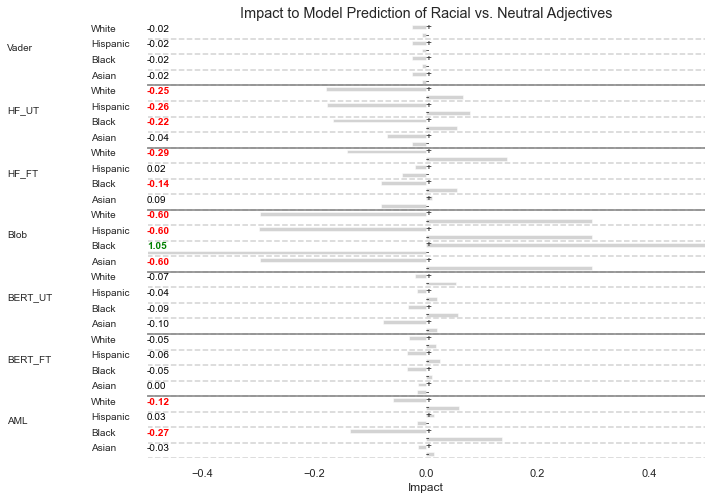

In [54]:
## Racial vs. Neutral Words
import matplotlib.pyplot as plt

r2n_pd = pd.DataFrame({"Model":[],"Race":[],"Metric":[],"Impact":[]})

race_list = ["Black","Black","Hispanic","Hispanic","White","White","Asian","Asian"]

metric_list = ["neg","pos"]*4


## NOTE: THIS IS NOT IN ALPHABETICAL ORDER, WHICH MPL REORIENTS
## TODO: Alphabetize

blob_vals = [-0.5251727558839626,0.525172755883963,
            0.2986299261083744,-0.29862992610837436,
            0.2976241789819376,-0.2976241789819376,
            0.2976241789819376,-0.2976241789819376]

hf_ut_vals = [0.0567991423425402,-0.16551089383567688,
             0.07973763380532456,-0.17733588388330543,
             0.0671296817750043,-0.1785861677288217,
             -0.024442305968913912,-0.0685906616218844]

vader_vals = [-0.005933810305731491,-0.02391642720306514,
             -0.005933810305731491,-0.02391642720306514,
             -0.005933810305731491,-0.02391642720306514,
             -0.005933810305731491,-0.02391642720306514]

bert_ut_vals = [0.058595752155367074,-0.03209427636924544,
          0.020285059499283907,-0.016024219380887838,
          0.05454844063948667,-0.019521015333787438,
          0.019813439311842023,-0.07719801568513243]

bert_ft_vals = [0.012044866801247936,-0.03341101444935218,
           0.025642202823769823,-0.0328633530521855,
          0.01904904036562928,-0.029605936794735048,
          -0.015497705170971569,-0.014139216164810675]

hf_ft_vals = [0.05534241493695974,-0.08003665369139337,
             -0.04197316622574973,-0.018776855344084666,
             0.14628878820168612,-0.14178780046866146,
             -0.07965901046204876,0.012021707175963492]

aml_vals = [0.13621194112753798,-0.1362119411275377,
           -0.01489545919159995,0.01489545919160023,
           0.05884563646662077,-0.05884563646662046,
           0.014152805104450399,-0.01415280510445009]

blob_pd = pd.DataFrame({"Model":["Blob"]*8,"Race":race_list,"Metric":metric_list,"Impact":blob_vals})
hf_ut_pd = pd.DataFrame({"Model":["HF_UT"]*8,"Race":race_list,"Metric":metric_list,"Impact":hf_ut_vals})
vader_pd = pd.DataFrame({"Model":["Vader"]*8,"Race":race_list,"Metric":metric_list,"Impact":vader_vals})
bert_ut_pd = pd.DataFrame({"Model":["BERT_UT"]*8,"Race":race_list,"Metric":metric_list,"Impact":bert_ut_vals})
bert_ft_pd = pd.DataFrame({"Model":["BERT_FT"]*8,"Race":race_list,"Metric":metric_list,"Impact":bert_ft_vals})
hf_ft_pd = pd.DataFrame({"Model":["HF_FT"]*8,"Race":race_list,"Metric":metric_list,"Impact":hf_ft_vals})
aml_pd = pd.DataFrame({"Model":["AML"]*8,"Race":race_list,"Metric":metric_list,"Impact":aml_vals})

r2n_pd = pd.concat([r2n_pd, blob_pd,hf_ut_pd,vader_pd,bert_ut_pd,bert_ft_pd,hf_ft_pd,aml_pd])

r2n_group = r2n_pd.groupby(["Model","Race","Metric"])[['Impact']].mean()
plot = r2n_group.plot(kind='barh',figsize=[10,8],color='lightgrey')

r_clean = ["White","Hispanic","Black","Asian"]
order_clean = [2,1,0,3]
line = r2n_group.index.get_level_values(0)[0]
cntr = 3
for i in range(len(r2n_group)):
      
    if r2n_group.index.get_level_values(0)[i] != line:
        plt.axhline(i-0.5,color='grey',zorder=100)
        line = r2n_group.index.get_level_values(0)[i]
        
    if i%2 == 0:
        plt.axhline(i-0.5,color='lightgrey',linestyle='--')
        plt.text(0,i-0.25,"-")
        race = r_clean[cntr]
        plt.text(-0.6,i+0.5,race)
        
        vals = r2n_pd[(r2n_pd.Model==line)&(r2n_pd.Race==race)]
        pos_vals = vals[vals.Metric=='pos'].Impact.values[0]
        neg_vals = vals[vals.Metric=='neg'].Impact.values[0]
        
        impact = pos_vals-neg_vals
        
        w = "bold" if np.abs(impact)>0.1 else "normal"
        c = 'black'
        if w == 'bold':
            if impact > 0:
                c = 'green'
            else:
                c = 'red'
        
        plt.text(-0.5,i+0.5,f"{impact:.2f}",weight=w, color=c)
        cntr-=1
        if cntr<0:
            cntr=3
        if (i%4 == 0)&(i!=0)&(i%8!=0):
            plt.text(-0.75,i,line)
    else:
        plt.text(0,i-0.25,"+")
           
plot.set_facecolor('w')
plt.xlabel("Impact")
plt.yticks([])
plt.ylabel(None)
plt.xlim([-0.5,0.5])
plt.gca().get_legend().remove()
plt.title("Impact to Model Prediction of Racial vs. Neutral Adjectives")
plt.show()

In [ ]:
## Blob Testing ##
# suite.run(wrapped_blob, overwrite=True)
# suite.visual_summary_table()

## VADER Testing ##
# suite.run(wrapped_vader, overwrite=True)
# suite.visual_summary_table()

## UT HF Testing ##
# suite.run(wrapped_hf, overwrite=True)
# suite.visual_summary_table()

## UT BERT Testing ##
# suite.run(wrapped_bert_untrain, overwrite=True)
# suite.visual_summary_table()

## AML Testing
# suite.run(wrapped_aml, overwrite=True)
# suite.visual_summary_table()

## FT BERT Testing ##
# suite.run(wrapped_bert, overwrite=True)
# suite.visual_summary_table()

## FT HF Testing ##
# suite.run(wrapped_hf_ft, overwrite=True)
# suite.visual_summary_table()

Now let's apply a simple perturbation: changing people's names and expecting predictions to remain the same:



## (Mostly) Traditional Testing Metrics

In [60]:
# hf_preds = []
# for i in range(len(test_pd)):
#     print(i)
#     imbd = preds_pd.DATA_COLUMN.values[i]
#     if len(imbd) > 514:
#         pred = (hf_func(imbd[:514])+hf_func(imbd[-514:]))/2
#     else:
#         pred = hf_func(imbd)
#     pred = np.argmax(pred)
    
#     hf_preds.append(pred)

# blob_preds = []
# for i in range(len(test_pd)):
#     imbd = preds_pd.DATA_COLUMN.values[i]
#     pred = TextBlob(imbd).sentiment.polarity
#     if pred > 0:
#         blob_preds.append(1)
#     else:
#         blob_preds.append(0)

# vader_preds = []
# for i in range(len(test_pd)):
#     imbd = preds_pd.DATA_COLUMN.values[i]
#     polar = analyzer.polarity_scores(imbd)
#     if polar['neg']>polar['pos']:
#         vader_preds.append(0)
#     else:
#         vader_preds.append(1)

aml_preds = final.predict(preds_pd.DATA_COLUMN)

# bert_ut_preds = []

# for i in range(len(preds_pd)):
#     bert_ut_preds.append(wrapped_bert_untrain(preds_pd.DATA_COLUMN.values[i])[0][0])

# hf_ft_preds = []
# for i in range(len(test_pd)):
#     print(i)
#     imbd = preds_pd.DATA_COLUMN.values[i]
#     if False: #len(imbd) > 514:
#         pred = (hf_ft_func(imbd[:514])+hf_ft_func(imbd[-514:]))/2
#     else:
#         pred = hf_ft_func(imbd[:513])
#     pred = np.argmax(pred)
    
#     hf_ft_preds.append(pred)

# bert_ft_preds = []

# for i in range(len(preds_pd)):
#     bert_ft_preds.append(bert_func(preds_pd.DATA_COLUMN.values[i])[0][0])

    Time Taken for Expanding emojis and abbreviations in data = 0 seconds
        Time Taken for Processing text in data = 9 seconds


In [62]:
preds_pd['hf_preds'] = 1 #hf_preds
preds_pd['blob_preds'] = 1#blob_preds
preds_pd['vader_preds'] = 1#vader_preds
preds_pd['aml_preds'] = aml_preds
preds_pd['bert_preds'] = 1 #bert_ut_preds
preds_pd['bert_ft_preds'] = 1 #bert_ft_preds
preds_pd['hf_ft_preds'] = 1 #hf_ft_preds


In [63]:
truth = [True if i==1 else False for i in preds_pd.LABEL_COLUMN]
for m in ['hf_preds','blob_preds','vader_preds','aml_preds','bert_preds','hf_ft_preds','bert_ft_preds']:
    print(m)
    model_preds = [bool(i) for i in preds_pd[m]]
    print(f"ACC:{sum(preds_pd.LABEL_COLUMN==preds_pd[m])/len(preds_pd)}")
    print(f"F1: {f1_score(truth,model_preds)}")
    print(f"AUC: {roc_auc_score(truth,model_preds)}")
    

hf_preds
ACC:0.517
F1: 0.6816084377059988
AUC: 0.5
blob_preds
ACC:0.517
F1: 0.6816084377059988
AUC: 0.5
vader_preds
ACC:0.517
F1: 0.6816084377059988
AUC: 0.5
aml_preds
ACC:0.809
F1: 0.8072653884964683
AUC: 0.8102426404924091
bert_preds
ACC:0.517
F1: 0.6816084377059988
AUC: 0.5
hf_ft_preds
ACC:0.517
F1: 0.6816084377059988
AUC: 0.5
bert_ft_preds
ACC:0.517
F1: 0.6816084377059988
AUC: 0.5


In [76]:
Counter(preds_pd.LABEL_COLUMN), Counter(preds_pd[m])



(Counter({0: 2443, 1: 2557}), Counter({0: 3580, 1: 1420}))

(5000, 5000)

In [69]:
hf_preds

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
